In [38]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
from scipy.spatial.distance import cdist
import src.tools as tools
from Bio import Phylo
from src.stop_codons import get_stop_codon_info
from src.coevolution import * 

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

# build_stop_codon_dataset(arf1_df.genome_id.unique())
stop_codon_df = pd.read_csv('../data/stop_codon.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count



In [41]:
# Downloaded and ran Prodigal on two genomes of Methanosarcina which (1) had Pyl (2) lost Pyl, and (3) 
# had their TAG usage revert back to the original form. If modifications in the release factor do play a role in 
# total re-coding, we would expect specific, conserved changes between aRF1 of these organisms and their closest relative_ids. 

def add_weird_genomes(arf1_df, genome_ids=['GCA_003164755.1', 'GCA_017883485.1']):
    arf1_ids = {'GCA_017883485.1':'JADGNM010000028.1_7',  'GCA_003164755.1':'PLUB01000075.1_62'} # From inspection of hmmer output files.
    df = list()
    for genome_id in genome_ids:
        fn_path = f'../data/{genome_id}.fna'
        fa_path = f'../data/{genome_id}.fa'

        row = {'genome_id':genome_id, 'id':arf1_ids.get(genome_id), 'description':''}
        row['has_pyl'] = False
        row['order'] = 'Methanosarcinales'
        row['genus'] = 'Methanosarcina'
        stop_codon_info = get_stop_codon_info(fa_path=fa_path, fn_path=fn_path)
        row['tag_percent'] = stop_codon_info['TAG'] / (stop_codon_info['TAG'] + stop_codon_info['TGA'] + stop_codon_info['TAA'])
        row['gc_content'] = stop_codon_info['gc_content']
        row['seq'] = FASTAFile().from_fasta(fa_path).to_df().loc[row['id']].seq
        df.append(row)
    df = pd.DataFrame(df).set_index('id')
    arf1_df = pd.concat([df, arf1_df])
    arf1_df = arf1_df[~arf1_df.index.duplicated(keep='first')].copy() # Make sure to not re-add if added. 
    return arf1_df

arf1_df = add_weird_genomes(arf1_df)

In [42]:

# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+ recoded'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl+'] = (arf1_df.tag_percent >= 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')

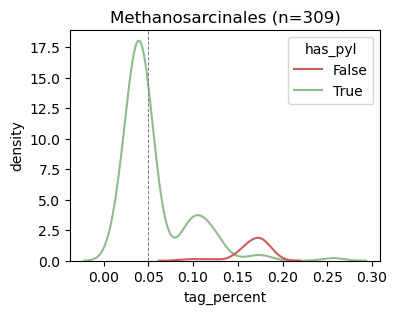

In [43]:
fig, ax = plt.subplots(figsize=(4, 3))

stop_codons = ['TAA', 'TGA', 'TAG']
palette = {True:'darkseagreen', False:'indianred'}

figure_df = arf1_df.copy()
figure_df = figure_df[figure_df.order == 'Methanosarcinales'].copy()
sns.kdeplot(figure_df, x='tag_percent', hue='has_pyl', palette=palette)
ax.set_ylabel('density')
ax.axvline(x=0.05, ls='--', color='gray', lw=0.7)
ax.set_title(f'Methanosarcinales (n={len(figure_df)})')

plt.show()

# Among Pyl+ archaea, when the TAG content drops below 5%, the extension length spikes. This seems like a reasonable threshold for 
# choosing organisms which might have aRF1 changes. 
 
# When the TAG content is higher, the extension lengths are generally lower. In this scenario, we might not expect the 
# release factor to look very different. Genomes are robust to Pyl incorporation and stop codon readthrough. 

# When the TAG content is lower, extension lengths are higher. In these genomes, it may
# be the case that the genomes have fully adapted to frequent Pyl; these are probably the "recoded" genomes.

In [45]:
arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].copy()
FASTAFile().from_df(arf1_df).write('../data/methanosarcinales_arf1.fa')
print(f'Removing all non-Methanosarcinales organisms from the DataFrame. {len(arf1_df)} sequences remaining.')

styles = {id_:'bold' for id_ in arf1_df[arf1_df.has_pyl].index}
sizes = {id_:2 for id_ in arf1_df[arf1_df.has_pyl].index}
tools.make_itol_annotation_file(arf1_df, field='tag_percent', path='../data/methanosarcinales_arf1_annotation_tag_percent.txt', styles=styles, sizes=sizes)

# palette = {'R':red, 'K':darkblue, 'M':darkgreen, '-':gray}
# tools.make_itol_annotation_file(arf1_df, field='residue_8', path='../data/methanosarcinales_arf1_tree_annotation_residue_8.txt', palette=palette)

palette = {'pyl+ recoded':darkgreen, 'pyl-':red, 'pyl+':lightblue}
tools.make_itol_annotation_file(arf1_df, field='category', path='../data/methanosarcinales_arf1_tree_annotation_category.txt', palette=palette)

Removing all non-Methanosarcinales organisms from the DataFrame. 309 sequences remaining.


In [96]:
# ids = arf1_df.index.tolist()
# ids.remove('JADGNM010000028.1_7')

index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=arf1_df.index) # Should load the sequences from Methanosarcinales only. 
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['has_pyl'] = arf1_df.has_pyl
alignment_df['category'] = arf1_df.category

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

load_msa: Num. conserved positions: 415
load_msa: Num. aligned sequences: 309
get_domain_boundaries: NIKS boundaries 55-59.
get_domain_boundaries: YxCxxxF boundaries 118-125.
get_domain_boundaries: GTS boundaries 23-26.


In [97]:
# Want to see if there are any changes in the aRF1s of the weird genomes which lost Pyl which are (1) not present in any of the closely-related
# aRF1s and (2) are present in the organisms which have adapted to Pyl incorporation by reducing TAG. 

tree = Phylo.read('../data/methanosarcinales_arf1.tree', format='newick')
tree.root_at_midpoint()

target_ids = ['JADGNM010000028.1_7', 'PLUB01000075.1_62']

relative_ids = list()
for target_id in target_ids:
    path = tree.get_path(target_id)
    node = path[-4] # Look four branches back. 
    relative_ids += [leaf.name for leaf in node.get_terminals()]

relative_ids = list(set(relative_ids))
relative_ids.remove('PLUB01000075.1_62')
relative_ids.remove('JADGNM010000028.1_7')

pyl_minus_and_high_tag_ids = arf1_df[(arf1_df.tag_percent > 0.1) & ~arf1_df.has_pyl].index.tolist()
pyl_minus_and_high_tag_ids.remove('PLUB01000075.1_62')

In [98]:
# index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=arf1_df.index) 
# alignment_df = pd.DataFrame(alignment, index=index)

def get_distinct_residues(target_id:str, alignment_df=None):
    target_residues = alignment_df.loc[target_id].values.reshape(-1, 1)
    other_residues = alignment_df[alignment_df.index != target_id].values.T
    positions = np.where(~np.any(target_residues == other_residues, axis=1))[0]
    return positions

# There are two residues in PLUB01000075.1_62 which are present in some Pyl- organisms, but not in any of the close relatives. 
# There are also several residues which are unique, both when compared to the Pyl- organisms and the close relatives. 
target_id = 'PLUB01000075.1_62'
positions = get_distinct_residues(target_id, alignment_df=alignment_df.loc[[target_id] + relative_ids].copy())
print(f'Residues distinct between {target_id} and close relatives:', ' '.join(positions.astype(str)))
positions = get_distinct_residues(target_id, alignment_df=alignment_df.loc[[target_id] + pyl_minus_and_high_tag_ids].copy())
print(f'Residues distinct between {target_id} and Pyl-, high TAG percent organisms:', ' '.join(positions.astype(str)))


Residues distinct between PLUB01000075.1_62 and close relatives: 7 8 35 40 115 258 270 355 360 415 416
Residues distinct between PLUB01000075.1_62 and Pyl-, high TAG percent organisms: 25 30 35 40 108 115 121 258 299 355 360 384


In [99]:

# Looking for a residue which non-Pyl using organisms seem to like, and Pyl-using organisms seem to dislike. 
# It seems like 8 might be a reasonable candidate?

# arf1_df['residue_8'] = alignment_df[8]
# print('Residues at position 8:', ' '.join(arf1_df.residue_8.unique()))
# palette = {'R':red, 'K':darkblue, 'M':darkgreen, '-':gray}

# tools.make_itol_annotation_file(arf1_df, field='residue_8', path='../data/methanosarcinales_arf1_tree_annotation_residue_8.txt', palette=palette)

# Lysine is not able to form as many hydrogen bonds, and may bind nucleic acids more weakly. 
# This is unusual, because you would think that Pyl- organisms would be more likely to have a strong nucleic acid
# binding residue, in order for it to be a stronger release factor (but perhaps it is interacting in some other way)


In [100]:
def plot_scores_2d(scores:np.ndarray, start=0, stop=150, ax:plt.Axes=None):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])
    plt.imshow(scores[start:stop, start:stop], cmap=cmap)
    ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_xticks(np.arange(start, stop), labels=np.arange(start, stop), fontsize='x-small')


def plot_scores_1d(scores:np.ndarray, start=0, stop=150, y_label:str='', ax:plt.Axes=None, color:str='steelblue'):
    scores = scores[start:stop]
    sns.lineplot(x=np.arange(len(scores)), y=scores, ax=ax, color=color)
    ax.set_xticks(np.arange(len(scores)), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_xlim(xmin=start, xmax=stop)
    ax.set_ylabel(y_label)

In [ ]:
# if not os.path.exists('scores_order_2.txt'):
#     cols = list(range(150)) + ['has_pyl']
#     mask = alignment_df.category.isin(['pyl+ recoded', 'pyl-'])
#     scores = get_scores(alignment_df[mask][cols].copy(), order=2)
#     with open('scores_order_2.txt', 'w') as f:
#         np.savetxt(f, scores)
# scores = np.loadtxt('scores_order_2.txt')

# Write scores comparing Pyl- and Pyl+ non-recoded, as well as Pyl+ and Pyl+ recoded. 

# DataFrame with the following fields:
# (1) score
# (2) position 
# (3) groups being compared
# (4) alignment length 
# groups = [('pyl+ recoded', 'pyl+'), ('pyl-', 'pyl+')]
# scores_df = list()
# for group_1, group_2 in groups:
#     scores = get_scores()


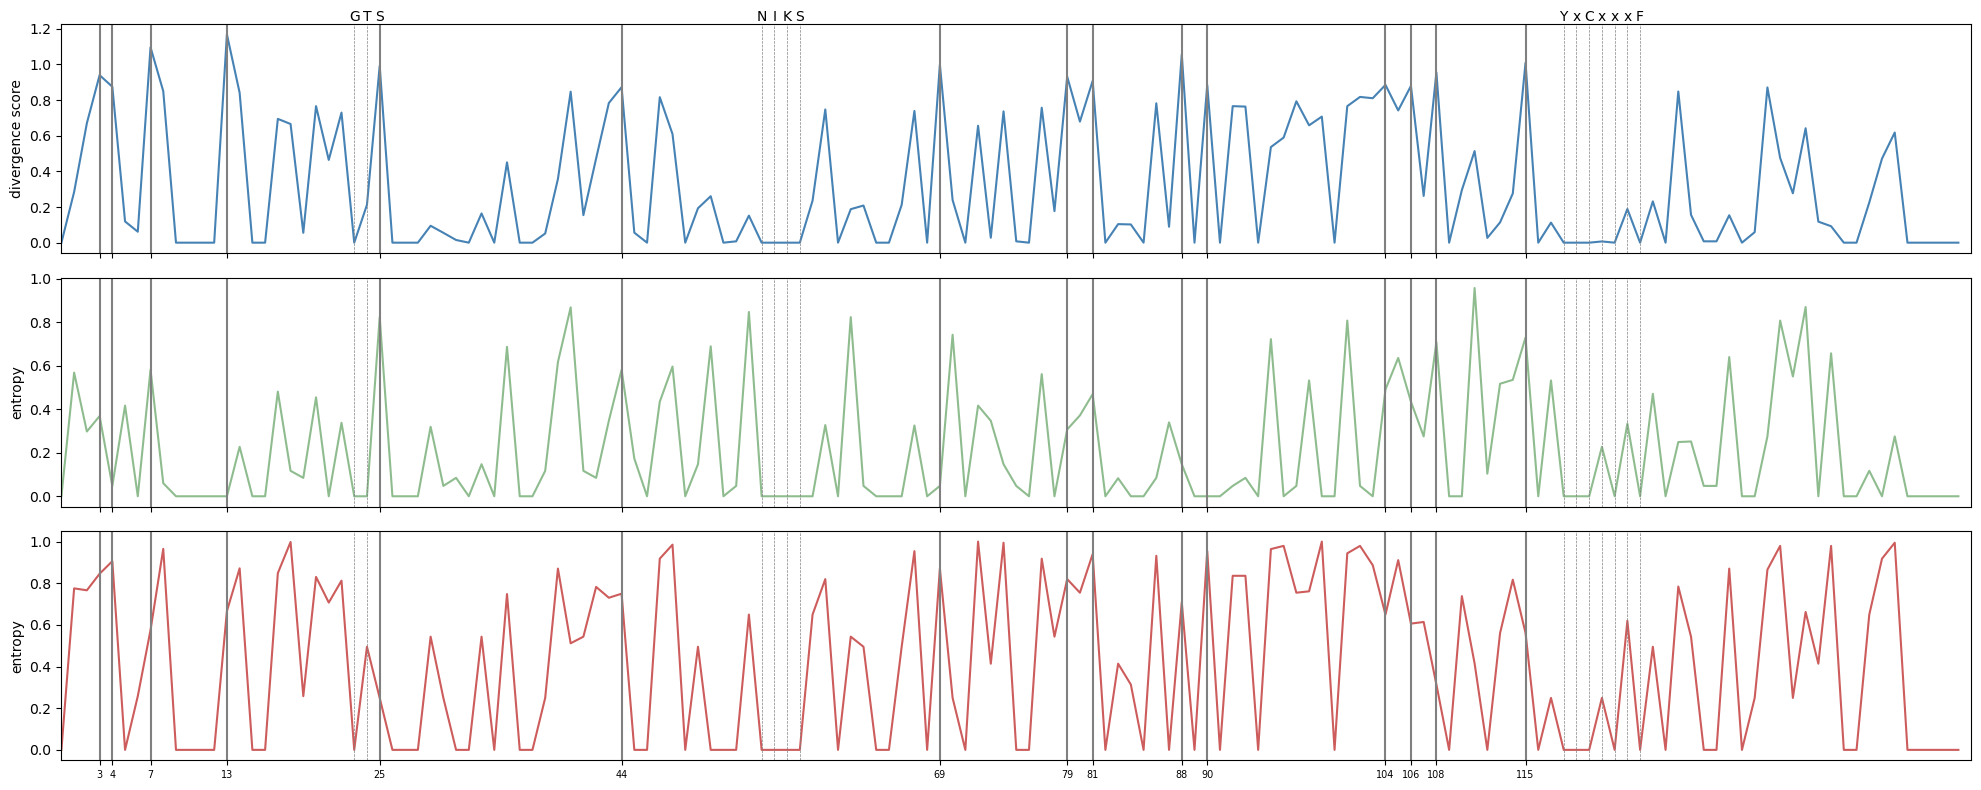

In [103]:
def annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']

figure_df = alignment_df.copy()
figure_df = figure_df[figure_df.category.isin(['pyl+ recoded', 'pyl-'])]
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()

fig, (ax_a, ax_b, ax_c) = plt.subplots(figsize=(20, 8), nrows=3, sharex=True)

divergence_scores = get_scores(figure_df)
plot_scores_1d(divergence_scores, ax=ax_a, y_label='divergence score')
markers = np.argsort(divergence_scores[:150])[::-1][:15]

plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl+ recoded'])[0], ax=ax_b, y_label='entropy', color='darkseagreen')
plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl-'])[0], ax=ax_c, y_label='entropy', color='indianred')

annotate_residues(domain_boundaries, ax=ax_a)
annotate_residues(domain_boundaries, ax=ax_b, lines_only=True)
annotate_residues(domain_boundaries, ax=ax_c, lines_only=True)

# for x in markers:
for ax in [ax_a, ax_b, ax_c]:
    for x in markers:
        ax.axvline(x, ls='-', color='gray')
ax_c.set_xticks(markers, labels=markers)

fig.tight_layout()
plt.show()
# What would be the maximum distance between two vectors that sum to one? sqrt(2)

# 7 8 35 40 115 

# Should note that the Pyl- group not as phylogenetically diverse as the Pyl+ group, so it is possible that residues which are conserved
# in the Pyl- group and not in the Pyl+ group may be due to phylogenetic signal. However, this also means that residues which are conserved
# in the Pyl+ group and not in the Pyl- group may be more more likely to be significant.

# We expect the recoded Pyl+ group to have changes to the release factor which weaken its ability to bind stop codons.  


Generating plots for 15 positions.


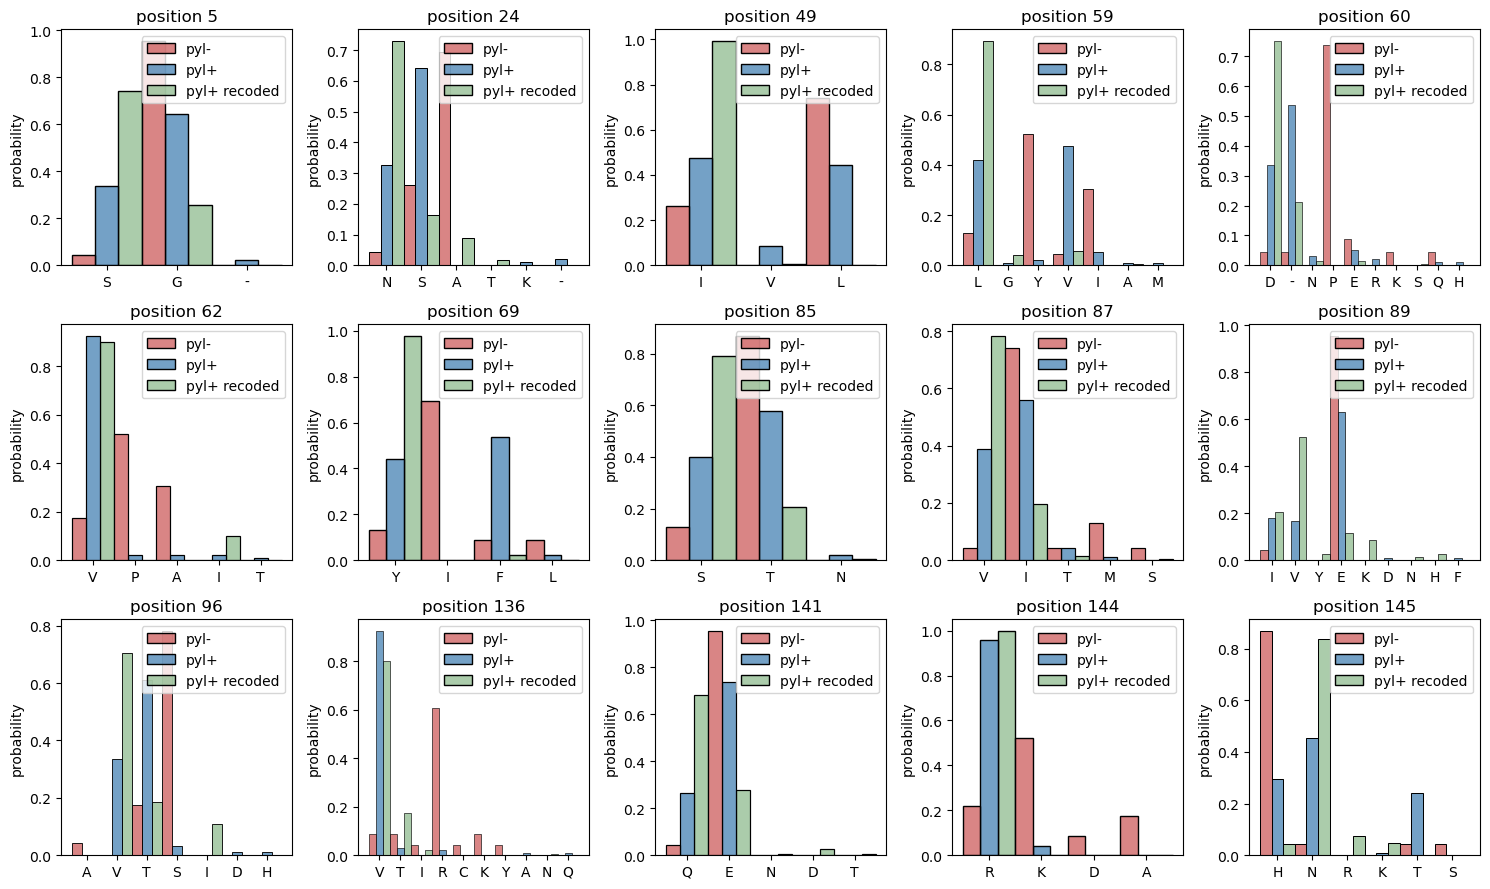

In [87]:
outlier_ids = ['KADGNM010000028.1 7', 'PLUB01000075.1 62', 'JACIVZ010000083.1 3']
positions = sorted(markers)
print(f'Generating plots for {len(positions)} positions.')

figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df = figure_df[~figure_df.index.isin(outlier_ids)].copy()

palette = {'pyl+ recoded':'darkseagreen', 'pyl+':'steelblue', 'pyl-':'indianred'}

n_rows = 3 
n_cols = 5

fig, axes = plt.subplots(figsize=(3 * n_cols, 3 * n_rows), nrows=n_rows, ncols=n_cols)
for ax, position in zip(axes.ravel(), positions):
    plot_residue_counts(figure_df, position=position, ax=ax, hue='category', palette=palette)
fig.tight_layout()
plt.show()

In [54]:
# No single signal, but perhaps if you look at the second-order scores, i.e. distribution of residue pairs?
# Worried about the mutual information metric, as it can be easily skewed by a single outlier